<center>
    <h1>Alcohol and Gross Domestic Product</h1>
    <h5>CMSC320 Final Project</h5>
    Valentyn Bolotin, Jacob Barats, Evan May
</center>
<hr>

<center>
    <h3>Introduction</h3>
</center>

Since its creation, alcohol has been a staple in human society. Every country at some point in history has drunk alcohol and today most countries still do. The difference between then and now is the change in restrictions on alcohol. While few countries like Kuwait have <a href="https://www.latimes.com/world/middleeast/la-fg-kuwait-islamists-alcohol-20150105-story.html#:~:text=Kuwait%20and%20Saudi%20Arabia%20are,people%20convicted%20of%20drinking%20alcohol">absolute bans on alcohol</a>, many have regulations in place to limit the amount of alcohol consumption for their citizens. The exact reasoning for these restrictions changes depending on the country but the general thought process is that when individuals consume less alcohol, they are better, more productive citizens. 

We want to challenge this reasoning by determining if a country's alcohol consumption impacts a country's gross domestic product (GDP). While a country's GDP is not a perfect reflection of the productivity of a country, there is enough correlation between the two that an analysis can be conducted.

<hr>

<center>
    <h3>Data collection/curation</h3>
</center>
To determine if alcohol consumption impacts a country's GDP, we need to wrangle data for a country's alcohol consumption and GDP. The problem was that many of these datasets were incomplete or over a small time frame. Our solution was wrangling data from several sources and filling out as much missing information as possible. We have listed all the datasets that we use in this tutorial below.  

* Our World in Data
    * <a href = "https://ourworldindata.org/alcohol-consumption">Alochol Consumption per Capita</a>
    * <a href = "https://ourworldindata.org/grapher/gdp-world-regions-stacked-area?tab=table&time=earliest..1991&country=GRC~DEU~GHA~GTM~GNB~GIN~GMB~GAB~GNQ~GEO">Gross Domestic Product (GDP) based on 2011 International Dollar ($)</a>
    * <a href = "https://ourworldindata.org/grapher/alcohol-consumption-vs-gdp-per-capita">Alochol Consumption per Capita vs GDP per Capita based on Purchasing Power Partiry (PPP) </a>
<br> 
* University of Groningen, Maddison Project Database 2018
    * <a href = "https://www.rug.nl/ggdc/historicaldevelopment/maddison/releases/maddison-project-database-2018">GDP per capita based on 2011 US Dollar with and without multiple benchmarks, Total Population </a>
<br> 
* The World Bank, International Comparison Program (ICP)
    * <a href = "https://ourworldindata.org/alcohol-consumption">Purchasing Power Partiry (PPP)</a>
<br>
* World Health Organization
    * <a href = "https://www.who.int/data/gho/data/indicators/indicator-details/GHO/alcohol-recorded-per-capita-(15-)-consumption-(in-litres-of-pure-alcohol)">Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)</a>

<hr>

<center>
    <h3>Parsing and Data management</h3>
</center>
To complete the tutorial the following imports are required:
<br>
Note that the warning import is just to avoid unnecessary output and it will still run without it.

In [72]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pandas.core.arrays import integer
from pandas.core.arrays.numeric import T
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from scipy.spatial import ConvexHull
from scipy import interpolate
import math
import scipy.ndimage
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

<h4>Finding the Best Range</h4>

As stated previously, the data we acquired had large amounts of missing data. Many countries did not record data for various reasons meaning the datasets contain sections of time where there is little to no meaningful data. If we were to take all of the data and perform an analysis on it, it would be too skewed by the missing data to produce any meaningful results. We decided to determine the range of years that had the most data.

First, we added the dataset from the Maddison Project Database. 

In [73]:
raw_data = pd.read_stata('Data/mpd2018.dta')
raw_df = pd.DataFrame(raw_data)
raw_df = raw_df.rename(columns= {"countrycode" : "code", "pop":"population",
                          "rgdpnapc":"gdp_pc_2011", "cgdppc":"gdp_pc_2011_mb"})
raw_df = raw_df.drop(columns=['i_cig', 'i_bm'])
combined_df = raw_df
combined_df

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population
0,AFG,Afghanistan,1820.0,NaN,NaN,3280.0
1,AFG,Afghanistan,1870.0,NaN,NaN,4207.0
2,AFG,Afghanistan,1913.0,NaN,NaN,5730.0
3,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0
4,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0
...,...,...,...,...,...,...
19868,ZWE,Zimbabwe,2012.0,1623.0,1604.0,12620.0
19869,ZWE,Zimbabwe,2013.0,1801.0,1604.0,13183.0
19870,ZWE,Zimbabwe,2014.0,1797.0,1594.0,13772.0
19871,ZWE,Zimbabwe,2015.0,1759.0,1560.0,14230.0


There is a large number of missing entries in our dataset. We need to find the section of the dataset that has the least number of missing data to conduct our analysis. To do this, we need to find the ranges in the dataset with the highest change over time. 

In [74]:
codes_arr = []

for code in pd.unique(combined_df.code):
  if isinstance(code, str):
    codes_arr.append(code)
combined_df = combined_df[combined_df.code.isin(codes_arr)]

years_arr = np.sort(pd.unique(combined_df.year).reshape(-1))

years_num = {}

for year in years_arr:
  num_entries = len(combined_df[combined_df.year == year].index)
  years_num[year] = num_entries

for i in range(0, len(years_arr)):
  year = years_arr[i]
  prev_year = year
  if i > 0:
    prev_year = years_arr[i-1]
  delta_t = year - prev_year
  delta_v = 0
  delta_vt = 0
  if delta_t > 0:
    delta_v = (years_num[year] - years_num[prev_year][0])
    delta_vt = float(delta_v)/float(delta_t)
  years_num[year] = [years_num[year], years_num[year] - len(codes_arr), delta_t,
                     delta_v, delta_vt]

high_delta_indicies = []

start_year = years_arr[0]
high_delta_indicies.append([0, np.abs(years_num[start_year][4]), 0, 0, 
          1.0 + float(years_num[start_year][1])/float(len(codes_arr)),
          1])
hd_index = 0

for i in range(1, len(years_arr)):
  year = years_arr[i]
  curr_dvt = np.abs(years_num[year][4])
  curr_dt = years_num[year][2]
  curr_dv = years_num[year][3]
  if(curr_dvt > 0.2 * float(years_num[year][0])):
    hd_index = hd_index + 1
    high_delta_indicies.append([i, curr_dvt, 0, curr_dt,
      1.0 + float(years_num[year][1])/float(len(codes_arr)), 1])
  else:
    tmp = high_delta_indicies[hd_index]
    tmp[2] = tmp[2] + curr_dv
    tmp[3] = tmp[3] + curr_dt
    tmp[4] = tmp[4] + 1.0 + float(years_num[year][1])/float(len(codes_arr))
    tmp[5] = tmp[5] + 1
    high_delta_indicies[hd_index] = tmp

tmp = []
for elt in high_delta_indicies:
  if elt[5] > 1:
    tmp.append(elt)

high_delta_indicies = tmp

#our output
for elt in high_delta_indicies[len(high_delta_indicies)-3:]:
  to_print = "Index: {}, year: {}, absDvt: {}, dv_ser: {}, dt: {}, adj_percent: {}"
  to_print = to_print.format(elt[0], years_arr[elt[0]], elt[1], elt[2], elt[3],
                             elt[4]/elt[3])
  print(to_print)                         


Index: 624, year: 1900.0, absDvt: 26.0, dv_ser: -9, dt: 13.0, adj_percent: 0.345471096950387
Index: 638, year: 1914.0, absDvt: 29.0, dv_ser: 8, dt: 36.0, adj_percent: 0.37689020381328076
Index: 674, year: 1950.0, absDvt: 103.0, dv_ser: 0, dt: 67.0, adj_percent: 1.0


* Index : Index in the array of all unique years
* Year : Year for that data
* absDvt : Absolute value of change over time in number of entries
* dv_ser : Sum of all changes in values after the index change
* dt : Delta time
* adj_percent : Ratio of numbers in this vs the entire set

Based on the analysis done we can now score each of the ranges and find the most suitable range to conduct our analysis on.

Using the information collected, we now can calculate the scores for each of the year ranges. 

In [75]:
hd_scores = []

for elt in high_delta_indicies:
  score = 0
  ## % covered
  score += elt[4]/elt[3]
  ## ~time step
  time_step = elt[3]/elt[5]
  time_step_score = np.exp(-(time_step - 1))
  score += time_step_score
  ## total entries
  score += elt[5]/len(years_arr)
  ## delta trend
  dt_score = float(elt[2])/float(len(codes_arr))
  dt_score = dt_score * elt[4]/elt[3]
  dt_score = dt_score/2.0 + 0.5
  score += dt_score
  hd_scores.append(score)

max_index = np.argmax(hd_scores)

print("Best index: {}, score: {}, start_year: {}, end_year: {}".format(
  max_index, hd_scores[max_index], years_arr[high_delta_indicies[max_index][0]],
  years_arr[high_delta_indicies[max_index][0]] + high_delta_indicies[max_index][3]
  - years_num[years_arr[high_delta_indicies[max_index][0]]][2]
))

Best index: 27, score: 2.5904183535762484, start_year: 1950.0, end_year: 2016.0


For our tutorial, we will use data from 1950 to 2016. This will make later analysis easier as there is a smaller likelihood of missing data. We can now remove the unnecessary rows from our data frame, which is around 8000 rows. 

In [76]:
start_year = years_arr[high_delta_indicies[max_index][0]]
end_year = start_year + high_delta_indicies[max_index][3]

combined_df = combined_df[combined_df.year >= start_year]
combined_df = combined_df[combined_df.year <= end_year]

combined_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population
3,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0
4,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0
5,AFG,Afghanistan,1952.0,2462.0,2462.0,8425.0
6,AFG,Afghanistan,1953.0,2568.0,2568.0,8573.0
7,AFG,Afghanistan,1954.0,2576.0,2576.0,8728.0


<h4>Finding the missing values</h4>
While the range of years we have found has the least amount of missing entries, there is still a relatively small amount in our data. In this tutorial, we want to make sure that we have as much GDP data as possible. To fill in this data we will extract more data from the Our World in Data dataset.

In [77]:
cpc_df = pd.read_csv('Data/alcohol-consumption-vs-gdp-per-capita.csv')
cpc_df = pd.DataFrame(cpc_df)

cpc_df = cpc_df.drop(labels = "Continent", axis = 1)
cpc_df = cpc_df.rename(columns= {"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)" : "consumption_for_person",
                                 "GDP per capita, PPP (constant 2017 international $)" : "gdp_pc_2017", "Population (historical estimates)": "population_cpc",
                                 "Entity" : "country", "Code":"code", "Year":"year"})
cpc_df = cpc_df[cpc_df.code.isin(codes_arr)]
cpc_df["total_liters_consumed"] = cpc_df.consumption_for_person * cpc_df.population_cpc
cpc_df = cpc_df[cpc_df.year > start_year]
future_cpc_df = cpc_df[cpc_df.year > end_year]

cpc_df = cpc_df[cpc_df.year <= end_year]
cpc_df.gdp_pc_2017 = cpc_df.gdp_pc_2017
cpc_df.head()

,country,code,year,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed
1,Afghanistan,AFG,2010,0.21,1957.029070,29185511.0,6128957.31
2,Afghanistan,AFG,2015,0.21,2068.265904,34413603.0,7226856.63
4,Afghanistan,AFG,2002,NaN,1189.784668,22600774.0,NaN
5,Afghanistan,AFG,2003,NaN,1235.810063,23680871.0,NaN
6,Afghanistan,AFG,2004,NaN,1200.278013,24726689.0,NaN


We can search for missing entries in the main data frame and attempt to fill it with the data in the new data frame. The dataset from Our World in Data has data on total alcohol consumption per capita so we can add that to our main data frame. Note that all missing entries from this point forward will be represented as -1.

In [78]:
hit_years_arr = np.sort(pd.unique(combined_df.year).reshape(-1))

temp_comb = combined_df

cpc_merge = cpc_df.drop(labels=["gdp_pc_2017","consumption_for_person", "population_cpc", "total_liters_consumed"],
                             axis = 1)

for code in codes_arr:
  cpc_code = cpc_merge[cpc_merge.code == code]
  combined_code = combined_df[combined_df.code == code]
  missing_years = np.array(hit_years_arr)
  sub_years = np.array(combined_code.year.to_numpy())
  missing_years = np.setdiff1d(missing_years, sub_years)
  
  if len(missing_years > 0):
    cpc_fill = cpc_code[cpc_code.year.isin(missing_years)]
    cpc_fill.index += len(temp_comb.index)
    temp_comb = pd.concat([temp_comb,cpc_fill])

cpc_merge = cpc_df.drop(labels = ["country"], axis = 1)
temp_comb = pd.merge(how = "left", left = temp_comb, right = cpc_merge, on=["code","year"])
temp_comb = temp_comb.fillna(-1)

combined_df = temp_comb
combined_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed
0,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0,-1.0,-1.0,-1.0,-1.0
1,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0,-1.0,-1.0,7840151.0,-1.0
2,AFG,Afghanistan,1952.0,2462.0,2462.0,8425.0,-1.0,-1.0,7935996.0,-1.0
3,AFG,Afghanistan,1953.0,2568.0,2568.0,8573.0,-1.0,-1.0,8039684.0,-1.0
4,AFG,Afghanistan,1954.0,2576.0,2576.0,8728.0,-1.0,-1.0,8151316.0,-1.0


We only want data that has a low amount of missing entries. Data that is missing all of its population data isn't helpful so we remove them.

In [79]:
missing_codes = {}
for code in codes_arr:
  pop = combined_df[combined_df.code == code]
  pop = pop[((pop.population < 0) | (pop.population_cpc < 0))]
  pop_arr = []
  for i, row in pop.iterrows():
    pop_arr.append(row.year)
  missing_codes[code] = pop_arr

def code_comp (a):
  return -len(missing_codes[a])

sorted_codes = sorted(codes_arr, key=code_comp)

rem_codes = []
for code in sorted_codes:
  if len(missing_codes[code]) == end_year - start_year:
    rem_codes.append(code)

combined_df = combined_df[~combined_df.code.isin(rem_codes)]
hit_codes = pd.unique(combined_df.code).reshape(-1)
combined_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed
0,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0,-1.0,-1.0,-1.0,-1.0
1,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0,-1.0,-1.0,7840151.0,-1.0
2,AFG,Afghanistan,1952.0,2462.0,2462.0,8425.0,-1.0,-1.0,7935996.0,-1.0
3,AFG,Afghanistan,1953.0,2568.0,2568.0,8573.0,-1.0,-1.0,8039684.0,-1.0
4,AFG,Afghanistan,1954.0,2576.0,2576.0,8728.0,-1.0,-1.0,8151316.0,-1.0


<h4>Additional tidying</h4>
We want to make sure that all of the data is in the same units. We change our population's scale to be one to one and make both our GDP columns be in terms of GDP per capita. This avoids problems of unit conversion in analysis later.

In [80]:
st_df = combined_df

st_df["population"] = st_df["population"] * 1000
st_df.population[st_df.population < 0] = -1

st_df["gdp_2011"] = st_df["gdp_pc_2011"] * st_df["population"]
st_df.gdp_2011[st_df.gdp_2011 < 0] = -1

st_df["gdp_2011_mb"] = st_df["gdp_pc_2011_mb"] * st_df["population"]
st_df.gdp_2011_mb[st_df.gdp_2011_mb < 0] = -1

st_df["gdp_2017"] = st_df["gdp_pc_2017"] * st_df["population_cpc"]
st_df.gdp_2017[st_df.gdp_2017 < 0] = -1

st_df["population"] = st_df["population"].astype(int)
st_df["population_cpc"] = st_df["population_cpc"].astype(int)
st_df["year"] = st_df["year"].astype(int)
st_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017
0,AFG,Afghanistan,1950,2392.0,2392.0,8150000,-1.0,-1.0,-1,-1.0,1.949480e+10,1.949480e+10,1.0
1,AFG,Afghanistan,1951,2422.0,2422.0,8284000,-1.0,-1.0,7840151,-1.0,2.006385e+10,2.006385e+10,-1.0
2,AFG,Afghanistan,1952,2462.0,2462.0,8425000,-1.0,-1.0,7935996,-1.0,2.074235e+10,2.074235e+10,-1.0
3,AFG,Afghanistan,1953,2568.0,2568.0,8573000,-1.0,-1.0,8039684,-1.0,2.201546e+10,2.201546e+10,-1.0
4,AFG,Afghanistan,1954,2576.0,2576.0,8728000,-1.0,-1.0,8151316,-1.0,2.248333e+10,2.248333e+10,-1.0


The 2017 GDP that was added to our dataset is in terms of the constant 2017 international dollar which is different than the 2011 GDP and the 2011 MB GDP. This causes issues when they are compared to one another in an analytical setting. Conversion factors are calculated for 2011 and 2016 are calculated for 2011, 2011 with multiple benchmarks, and 2017.

In [81]:
y1_df = combined_df[combined_df.year == 2011]
y2_df = combined_df[combined_df.year == 2016]
y1_vals = {"gdp_2011":0, "gdp_2011_mb":0, "gdp_2017":0}
y2_vals = {"gdp_2011":0, "gdp_2011_mb":0, "gdp_2017":0}
for code in hit_codes:
  c_df = y1_df[combined_df.code == code]
  for v in c_df["gdp_2011"]:
    y1_vals["gdp_2011"] = y1_vals["gdp_2011"] + v
  for v in c_df["gdp_2011_mb"]:
    y1_vals["gdp_2011_mb"] = y1_vals["gdp_2011_mb"] + v
  for v in c_df["gdp_2017"]:
    y1_vals["gdp_2017"] = y1_vals["gdp_2017"] + v
  c_df = y2_df[combined_df.code == code]
  for v in c_df["gdp_2011"]:
    y2_vals["gdp_2011"] = y2_vals["gdp_2011"] + v
  for v in c_df["gdp_2011_mb"]:
    y2_vals["gdp_2011_mb"] = y2_vals["gdp_2011_mb"] + v
  for v in c_df["gdp_2017"]:
    y2_vals["gdp_2017"] = y2_vals["gdp_2017"] + v

y1_vals["fac1"] = y1_vals["gdp_2011"] / y1_vals["gdp_2017"]
y1_vals["fac2"] = y1_vals["gdp_2011_mb"] / y1_vals["gdp_2017"]
y1_vals["fac2011"] = y1_vals["gdp_2011_mb"] / y1_vals["gdp_2011"]

y2_vals["fac1"] = y2_vals["gdp_2011"] / y2_vals["gdp_2017"]
y2_vals["fac2"] = y2_vals["gdp_2011_mb"] / y2_vals["gdp_2017"]
y2_vals["fac2011"] = y2_vals["gdp_2011_mb"] / y2_vals["gdp_2011"]

print(y1_vals)
print(y2_vals)

combined_df[combined_df.code == "USA"].head()

{'gdp_2011': 93952331058496.0, 'gdp_2011_mb': 93952331058496.0, 'gdp_2017': 98171539732185.94, 'fac1': 0.957022079054683, 'fac2': 0.957022079054683, 'fac2011': 1.0}
{'gdp_2011': 107295416080637.0, 'gdp_2011_mb': 106491490024125.0, 'gdp_2017': 115602680525130.58, 'fac1': 0.9281395171222896, 'fac2': 0.92118530072471, 'fac2011': 0.9925073587868114}


,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017
10720,USA,United States,1950,15241.0,15241.0,152271008,-1.0,-1.0,-1,-1.0,2.320762e+12,2.320762e+12,1.0
10721,USA,United States,1951,16126.0,16126.0,154878000,-1.0,-1.0,160872264,-1.0,2.497563e+12,2.497563e+12,-1.0
10722,USA,United States,1952,16443.0,16443.0,157552992,-1.0,-1.0,163266026,-1.0,2.590644e+12,2.590644e+12,-1.0
10723,USA,United States,1953,16917.0,16917.0,160184000,-1.0,-1.0,165909996,-1.0,2.709833e+12,2.709833e+12,-1.0
10724,USA,United States,1954,16513.0,16513.0,163026000,-1.0,-1.0,168736390,-1.0,2.692048e+12,2.692048e+12,-1.0


<h4>Created the world dataset</h4>
We now have data for country and year but we want to make an easy to access data that has the yearly sum for many of these columns such as GDP and total alcohol consumption. We create a world dataset to accomplish this.

In [82]:
world_df = pd.DataFrame(columns= combined_df.columns)
world_miss_df = pd.DataFrame(columns= world_df.columns).drop(labels = ["country", "code"], axis = 1)

common_attrs = ["population",
                "population_cpc",
                "consumption_for_person",
                "gdp_pc_2011_mb",
                "gdp_pc_2011",
                "gdp_pc_2017",
                "total_liters_consumed",
                "gdp_2011_mb",
                "gdp_2011",
                "gdp_2017"]

frac_attrs =   ["gdp_pc_2011_mb",
                "gdp_pc_2011",
                "gdp_pc_2017",
                "consumption_for_person"]

map_attrs =    {"gdp_pc_2011_mb" : "gdp_2011_mb",
                "gdp_pc_2011" : "gdp_2011",
                "gdp_pc_2017": "gdp_2017",
                "consumption_for_person" : "total_liters_consumed"}

for year in hit_years_arr:
  year_df = combined_df[combined_df.year == year]
  ser = pd.Series()
  ser["country"] = "WORLD"
  ser["code"] = "WORLD"
  ser["year"] = year

  ser_miss = pd.Series()
  ser_miss["year"] = year
  
  for attr in common_attrs:
    ser[attr] = 0
    ser_miss[attr] = []

  for i, row in year_df.iterrows():
    for attr in common_attrs:
      if row[attr] > 0:
        ser[attr] = row[attr] + ser[attr]
      else:
        ser_miss[attr].append(row["code"])

  for attr in common_attrs:
    if ser[attr] == 0:
      ser[attr] = -1


  for attr in frac_attrs:
    if ser[attr] > 0:
      ser[attr] = ser[map_attrs[attr]] / ser["population"]
  world_df.loc[len(world_df.index)] = ser
  world_miss_df.loc[len(world_miss_df.index)] = ser_miss

world_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017
0,WORLD,WORLD,1950.0,2840.316642,3193.007878,2514160984,-1,-1,-1,-1,8027735828641.0,7141013283921.0,166.0
1,WORLD,WORLD,1951.0,2985.611376,3355.141447,2557931000,-1,-1,2572198645,-1,8582220316169.0,7636987893105.0,-1
2,WORLD,WORLD,1952.0,3067.791124,3456.668876,2610876008,-1,-1,2618839562,-1,9024933836048.0,8009622243888.0,-1
3,WORLD,WORLD,1953.0,3191.232846,3591.33825,2658728016,-1,-1,2665387479,-1,9548391621048.0,8484620172448.0,-1
4,WORLD,WORLD,1954.0,3204.739537,3626.651794,2709558016,-1,-1,2712412149,-1,9826623440912.0,8683427700912.0,-1


Using this data we can but the fraction of the GDP, alcohol consumed, and the population that a country represents for a given year. This is merged with the main data frame.

In [83]:
comb_df = pd.concat([combined_df,world_df], ignore_index = True)

comb_df["frac_gdp_2011"] = -1
comb_df["frac_gdp_2011_mb"] = -1
comb_df["frac_gdp_2017"] = -1
comb_df["frac_liters_consumed"] = -1
comb_df["frac_population"] = -1
comb_df["frac_population_cpc"] = -1

for year in hit_years_arr:
  total = world_df[world_df.year == year].gdp_2011.to_numpy()[0]
  comb_df.frac_gdp_2011[comb_df.year == year] = comb_df.gdp_2011 / total

  total = world_df[world_df.year == year].gdp_2011_mb.to_numpy()[0]
  comb_df.frac_gdp_2011_mb[comb_df.year == year] = comb_df.gdp_2011_mb / total

  total = world_df[world_df.year == year].gdp_2017.to_numpy()[0]
  comb_df.frac_gdp_2017[comb_df.year == year] = comb_df.gdp_2017 / total

  total = world_df[world_df.year == year].total_liters_consumed.to_numpy()[0]
  comb_df.frac_liters_consumed[comb_df.year == year] = comb_df.total_liters_consumed / total

  total = world_df[world_df.year == year].population.to_numpy()[0]
  comb_df.frac_population[comb_df.year == year] = comb_df.population / total

  total = world_df[world_df.year == year].population_cpc.to_numpy()[0]
  comb_df.frac_population_cpc[comb_df.year == year] = comb_df.population_cpc / total

comb_df.frac_gdp_2011[comb_df["gdp_2011"] == -1] = -1
comb_df.frac_gdp_2011_mb[comb_df["gdp_2011_mb"] == -1] = -1
comb_df.frac_gdp_2017[comb_df["gdp_2017"] == -1] = -1
comb_df.frac_liters_consumed[comb_df["total_liters_consumed"] == -1] = -1
comb_df.frac_population[comb_df["population"] == -1] = -1
comb_df.frac_population_cpc[comb_df["population_cpc"] == -1] = -1

comb_df[comb_df.code == "USA"].head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017,frac_gdp_2011,frac_gdp_2011_mb,frac_gdp_2017,frac_liters_consumed,frac_population,frac_population_cpc
10586,USA,United States,1950,15241.0,15241.0,152271008,-1.0,-1.0,-1,-1.0,2320762404864.0,2320762404864.0,1.0,0.289093,0.324991,0.006024,-1,0.060565,-1
10587,USA,United States,1951,16126.0,16126.0,154878000,-1.0,-1.0,160872264,-1.0,2497562542080.0,2497562542080.0,-1.0,0.291016,0.327035,-1,-1,0.060548,0.062543
10588,USA,United States,1952,16443.0,16443.0,157552992,-1.0,-1.0,163266026,-1.0,2590643847168.0,2590643847168.0,-1.0,0.287054,0.323441,-1,-1,0.060345,0.062343
10589,USA,United States,1953,16917.0,16917.0,160184000,-1.0,-1.0,165909996,-1.0,2709832597504.0,2709832597504.0,-1.0,0.2838,0.319382,-1,-1,0.060248,0.062246
10590,USA,United States,1954,16513.0,16513.0,163026000,-1.0,-1.0,168736390,-1.0,2692048224256.0,2692048224256.0,-1.0,0.273955,0.310021,-1,-1,0.060167,0.062209


We now have the data for the GDP and overall alcohol consumption per year for each country and in terms of the world. For our tutorial we want to compare the specific types of alcohol to one another. We import the dataset from the World Health Organization which has data about specific types of alcohol consumption by country. We remove the rows outside of our time range.

In [84]:
acp_df = pd.read_csv("Data/who-alcohol-per-cap.csv")
acp_df = pd.DataFrame(acp_df)

acp_df = acp_df.drop(labels= ["IndicatorCode","Indicator","ValueType","ParentLocationCode","ParentLocation", "Location type","Period type"], axis = 1)
acp_df = acp_df.rename(columns={"SpatialDimValueCode" : "code"})

filtered_acp_df = pd.DataFrame(columns= ["code", "year",
                                         "wine_mi", "wine_hi", "wine_lo",
                                         "beer_mi", "beer_hi", "beer_lo", 
                                         "spirits_mi", "spirits_hi", "spirits_lo", 
                                         "other_mi", "other_hi", "other_lo",
                                         "total_mi", "total_hi", "total_lo"])

for code in pd.unique(acp_df.code):
  c_df = acp_df[acp_df.code == code]
  for year in pd.unique(c_df.Period):
    y_df = c_df[c_df.Period == year]
    ser = pd.Series(index=filtered_acp_df.columns)
    ser["code"] = code
    ser["year"] = year
    got_ser = 0

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_WINE"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["wine_hi"] = got_ser["FactValueNumericHigh"]
      ser["wine_mi"] = got_ser["FactValueNumeric"]
      ser["wine_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_BEER"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["beer_hi"] = got_ser["FactValueNumericHigh"]
      ser["beer_mi"] = got_ser["FactValueNumeric"]
      ser["beer_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_SPIRITS"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["spirits_hi"] = got_ser["FactValueNumericHigh"]
      ser["spirits_mi"] = got_ser["FactValueNumeric"]
      ser["spirits_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_OTHER_ALCOHOL"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["other_hi"] = got_ser["FactValueNumericHigh"]
      ser["other_mi"] = got_ser["FactValueNumeric"]
      ser["other_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_TOTAL"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["total_hi"] = got_ser["FactValueNumericHigh"]
      ser["total_mi"] = got_ser["FactValueNumeric"]
      ser["total_lo"] = got_ser["FactValueNumericLow"]

    filtered_acp_df.loc[len(filtered_acp_df.index)] = ser

hit_acp_df = filtered_acp_df[filtered_acp_df.code.isin(hit_codes)]
hit_acp_df = hit_acp_df[hit_acp_df.year.isin(hit_years_arr)]

hit_acp_df = hit_acp_df.fillna(-1)
hit_acp_df.head()

,code,year,wine_mi,wine_hi,wine_lo,beer_mi,beer_hi,beer_lo,spirits_mi,spirits_hi,spirits_lo,other_mi,other_hi,other_lo,total_mi,total_hi,total_lo
3,AFG,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.014,0.006,0.00,0.000,0.000,0.01,0.014,0.006
4,AFG,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000
5,AFG,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.014,0.006,0.00,0.000,0.000,0.01,0.014,0.006
6,AFG,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.01,0.014,0.006,0.01,0.014,0.006
7,AFG,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.01,0.014,0.006,0.01,0.014,0.006


In [85]:
miss_year = pd.DataFrame(columns=["year",
                                  "miss_wine", "miss_wine_range",
                                  "miss_beer", "miss_beer_range", 
                                  "miss_spirits", "miss_spirits_range", 
                                  "miss_other", "miss_other_range",
                                  "miss_total", "miss_total_range"])

for year in hit_years_arr:
  year_df = hit_acp_df[hit_acp_df.year == year]
  if len(year_df.index) < 1:
    0==0
  else:
    offset = len(hit_codes) - len(year_df)
    ser = pd.Series(index = miss_year.columns)
    ser["miss_wine"] = len(year_df[year_df.wine_mi == -1].index) + offset
    ser["miss_wine_range"] = len(year_df[(year_df.wine_hi == -1) | (year_df.wine_lo == -1)].index) + offset
    ser["miss_beer"] = len(year_df[year_df.beer_mi == -1].index) + offset
    ser["miss_beer_range"] = len(year_df[(year_df.beer_hi == -1) | (year_df.beer_lo == -1)].index) + offset
    ser["miss_spirits"] = len(year_df[year_df.spirits_mi == -1].index) + offset
    ser["miss_spirits_range"] = len(year_df[(year_df.spirits_hi == -1) | (year_df.spirits_lo == -1)].index) + offset
    ser["miss_other"] = len(year_df[year_df.other_mi == -1].index) + offset
    ser["miss_other_range"] = len(year_df[(year_df.other_hi == -1) | (year_df.other_lo == -1)].index) + offset
    ser["miss_total"] = len(year_df[year_df.total_mi == -1].index) + offset
    ser["miss_total_range"] = len(year_df[(year_df.total_hi == -1) | (year_df.total_lo == -1)].index) + offset
    ser["year"] = year
    miss_year.loc[len(miss_year.index)] = ser


miss_year["score"] = 200 - (25 * miss_year['miss_beer']/len(hit_codes) +
                            5 * miss_year['miss_beer_range']/len(hit_codes) +
                            25 * miss_year['miss_wine']/len(hit_codes) + 
                            5 * miss_year['miss_wine_range']/len(hit_codes) + 
                            25 * miss_year['miss_spirits']/len(hit_codes) + 
                            5 * miss_year['miss_spirits_range']/len(hit_codes) + 
                            10 * miss_year['miss_other']/len(hit_codes) + 
                            5 * miss_year['miss_other_range']/len(hit_codes) + 
                            90 * miss_year['miss_total']/len(hit_codes) + 
                            5 * miss_year['miss_total_range']/len(hit_codes))

miss_year.head()

,year,miss_wine,miss_wine_range,miss_beer,miss_beer_range,miss_spirits,miss_spirits_range,miss_other,miss_other_range,miss_total,miss_total_range,score
0,1960.0,164.0,166.0,164.0,166.0,164.0,166.0,166.0,166.0,164.0,166.0,1.987952
1,1961.0,40.0,166.0,40.0,166.0,40.0,166.0,123.0,166.0,40.0,166.0,127.831325
2,1962.0,38.0,166.0,38.0,166.0,38.0,166.0,123.0,166.0,38.0,166.0,129.819277
3,1963.0,31.0,166.0,31.0,166.0,31.0,166.0,122.0,166.0,31.0,166.0,136.837349
4,1964.0,31.0,166.0,31.0,166.0,31.0,166.0,122.0,166.0,31.0,166.0,136.837349


We then extract the viable data entries and merge them into our main data frame. The rows are merged if they have the same code and year.

In [86]:
viable_years = miss_year[miss_year.score > 180].year.to_numpy()
viable_acp_df = hit_acp_df[hit_acp_df.year.isin(viable_years)]
new_comb_df = pd.merge(how = "left", left = comb_df[comb_df.year.isin(viable_years)], right = viable_acp_df, on=["code","year"])
new_comb_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,...,beer_lo,spirits_mi,spirits_hi,spirits_lo,other_mi,other_hi,other_lo,total_mi,total_hi,total_lo
0,AFG,Afghanistan,2000,735.0,735.0,22461000,-1.0,-1.0,20779957,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,2001,692.0,692.0,22507000,-1.0,-1.0,21606992,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,2002,1088.0,1088.0,23600000,-1.0,1189.784668,22600774,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,2003,1112.0,1112.0,25005000,-1.0,1235.810063,23680871,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,2004,1107.0,1107.0,25698000,-1.0,1200.278013,24726689,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using the information from the from the <a href = "https://www.who.int/data/gho/data/indicators/indicator-details/GHO/alcohol-recorded-per-capita-(15-)-consumption-(in-litres-of-pure-alcohol)">World Health Organization</a>, we can calculate values of volume per type of alcohol consumed. For our purposes the average for wine, beer, spirits, and other were taken to use against the data collected in the previous section.

In [87]:
# From the World Health Organization
wine_abv = [0.12,0.09,0.16]
beer_abv = [0.05]
spirits_abv = [0.4,0.3]
other_abv = [0.05,0.05,0.17,0.18,0.09,0.09,0.09]

wine_abv = np.mean(wine_abv)
beer_abv = np.mean(beer_abv)
spirits_abv = np.mean(spirits_abv)
other_abv = np.mean(other_abv)

new_comb_df["wine_mi_vol"] = new_comb_df["wine_mi"] / wine_abv
new_comb_df["wine_hi_vol"] = new_comb_df["wine_hi"] / wine_abv
new_comb_df["wine_lo_vol"] = new_comb_df["wine_lo"] / wine_abv
new_comb_df["beer_mi_vol"] = new_comb_df["beer_mi"] / beer_abv
new_comb_df["beer_hi_vol"] = new_comb_df["beer_hi"] / beer_abv
new_comb_df["beer_lo_vol"] = new_comb_df["beer_lo"] / beer_abv
new_comb_df["spirits_mi_vol"] = new_comb_df["spirits_mi"] / spirits_abv
new_comb_df["spirits_hi_vol"] = new_comb_df["spirits_hi"] / spirits_abv
new_comb_df["spirits_lo_vol"] = new_comb_df["spirits_lo"] / spirits_abv
new_comb_df["other_mi_vol"] = new_comb_df["other_mi"] / other_abv
new_comb_df["other_hi_vol"] = new_comb_df["other_hi"] / other_abv
new_comb_df["other_lo_vol"] = new_comb_df["other_lo"] / other_abv

new_comb_df["total_mi_vol"] = new_comb_df["wine_mi_vol"] + new_comb_df["beer_mi_vol"] + new_comb_df["spirits_mi_vol"] + new_comb_df["other_mi_vol"]
new_comb_df["total_hi_vol"] = new_comb_df["wine_hi_vol"] + new_comb_df["beer_hi_vol"] + new_comb_df["spirits_hi_vol"] + new_comb_df["other_hi_vol"]
new_comb_df["total_lo_vol"] = new_comb_df["wine_lo_vol"] + new_comb_df["beer_lo_vol"] + new_comb_df["spirits_lo_vol"] + new_comb_df["other_lo_vol"]

new_comb_df["consumption_for_person"][new_comb_df.consumption_for_person < 0] = new_comb_df["total_mi"]
new_comb_df["fluid_vol_mi"] = new_comb_df["total_mi_vol"] * new_comb_df["population"]
new_comb_df["vol_vs_pure_mi"] = new_comb_df["total_mi"] / new_comb_df["total_mi_vol"]
new_comb_df[new_comb_df.code == "USA"].head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,...,spirits_hi_vol,spirits_lo_vol,other_mi_vol,other_hi_vol,other_lo_vol,total_mi_vol,total_hi_vol,total_lo_vol,fluid_vol_mi,vol_vs_pure_mi
2686,USA,United States,2000,45887.0,45887.0,282737984,9.19,50124.891177,281710914,2588923299.66,...,9.600000,4.085714,0.0,0.0,0.0,108.800772,150.572973,66.161390,30762110989.689571,0.075459
2687,USA,United States,2001,45878.0,45878.0,285550016,8.25,50126.720222,284607992,-1.0,...,9.771429,4.400000,0.0,0.0,0.0,109.600772,154.268726,66.637838,31296502255.542858,0.075273
2688,USA,United States,2002,46267.0,46267.0,288212000,8.33,50528.788577,287279312,-1.0,...,9.600000,4.114286,0.0,0.0,0.0,110.249421,153.908108,67.514286,31775206081.853279,0.075556
2689,USA,United States,2003,47158.0,47158.0,290700000,8.4,51529.726404,289815567,-1.0,...,10.114286,4.485714,0.0,0.0,0.0,109.316602,150.265637,68.610039,31778336293.436287,0.076841
2690,USA,United States,2004,48493.0,48493.0,293401984,8.48,52994.55196,292354663,-1.0,...,10.400000,4.514286,0.0,0.0,0.0,109.645560,150.081081,67.719691,32170224795.477993,0.077340


<hr>

<center>
    <h3>Exploratory data analysis</h3>
</center>

To show a relationship between GDP and alcohol consumption, we graph the median consumption per person and the logarithmically scaled GDP per capita. 

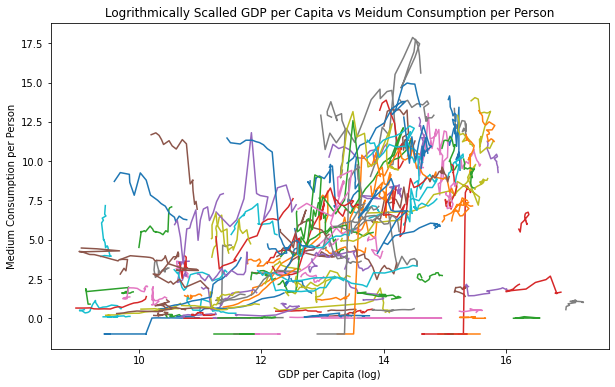

In [88]:
plt.figure(figsize=[10,6])
plt.title("Logrithmically Scalled GDP per Capita vs Meidum Consumption per Person")
plt.xlabel("GDP per Capita (log)")
plt.ylabel("Medium Consumption per Person")
for code in hit_codes:
  plottable = new_comb_df.fillna(-1)[new_comb_df.code == code]
  plottable = plottable[plottable.population != -1]
  plot_gdp = []
  plot_medcon = []
  for i, row in plottable.iterrows():
    plot_gdp.append(np.log2(row.gdp_pc_2011))
    plot_medcon.append(row.total_mi)
  plt.plot(plot_gdp, plot_medcon)


Each line on the graph represents a country in our data. Looking at the data we can see a vague pattern in the data. The data becomes much clearer when you create the same graph but over time.

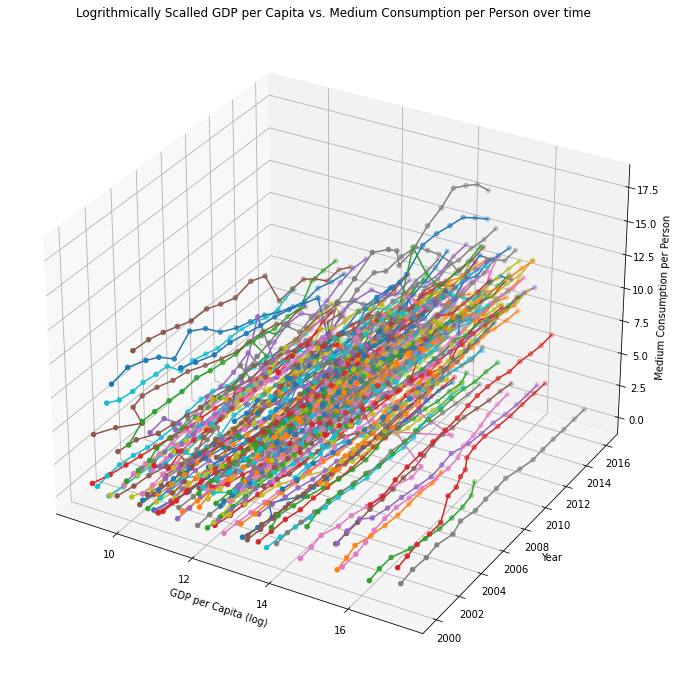

In [89]:
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection='3d')

new_comb_df = new_comb_df.fillna(-1)

ax.set_xlabel('GDP per Capita (log)')
ax.set_ylabel('Year')
ax.set_zlabel('Medium Consumption per Person');
ax.title.set_text("Logrithmically Scalled GDP per Capita vs. Medium Consumption per Person over time")
all_pts = []
all_x = []
all_y = []
all_z = []
for code in hit_codes:
  x = []
  y = []
  z = []
  code_df = new_comb_df[new_comb_df.code == code]
  for year in pd.unique(new_comb_df.year):
    y_df = code_df[code_df.year == year]
    xvar = np.log2(y_df["gdp_pc_2011"].to_numpy()[0])
    yvar = year
    zvar = y_df["total_mi"].to_numpy()[0]
    if xvar > 0 and yvar > 0 and zvar > 0:
      x.append(xvar)
      y.append(yvar)
      z.append(zvar)
      all_pts.append([xvar,yvar,zvar])
      all_x.append(xvar)
      all_y.append(yvar)
      all_z.append(zvar)
  ax.plot3D(x,y,z)
  ax.scatter3D(x,y,z)

We attempted to create a gaussian blur however we did not end up using it. This is because as an entropy function it lost a large amount of the data.

In [90]:
def _gaussian_kernel1d(sigma, order, radius):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    if order < 0:
        raise ValueError('order must be non-negative')
    exponent_range = np.arange(order + 1)
    sigma2 = sigma * sigma
    x = np.arange(-radius, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    if order == 0:
        return phi_x
    else:
        q = np.zeros(order + 1)
        q[0] = 1
        D = np.diag(exponent_range[1:], 1)  # D @ q(x) = q'(x)
        P = np.diag(np.ones(order)/-sigma2, -1)  # P @ q(x) = q(x) * p'(x)
        Q_deriv = D + P
        for _ in range(order):
            q = Q_deriv.dot(q)
        q = (x[:, None] ** exponent_range).dot(q)
        return q * phi_x

In [91]:
def make_surf_plot_points(pts, step, smooth_fac, f, sigma = 100, truncate = 4.0, add_x_bound = (0,0), add_y_bound = (0,0), blur_iter = 1, smooth_kind = 2, adj_blur = True):
  order = 0
  x_min = np.Infinity
  x_max = -np.Infinity
  y_min = np.Infinity
  y_max = -np.Infinity

  for pt in pts:
    x = pt[0]
    y = pt[1]
    if x < x_min:
      x_min = x
    elif x > x_max:
      x_max = x
    if y < y_min:
      y_min = y
    elif y > y_max:
      y_max = y
    
  x_add = (add_x_bound[0] + add_x_bound[1])/((x_max - x_min)/step)
  y_add = (add_y_bound[0] + add_y_bound[1])/((y_max - y_min)/step)

  x_max = x_max + add_x_bound[1]
  x_min = x_min - add_x_bound[0]
  y_max = y_max + add_y_bound[1]
  y_min = y_min - add_y_bound[0]

  step = step + math.ceil(np.max([x_add, y_add]))

  x_arr = np.linspace(x_min,x_max,step)
  y_arr = np.linspace(y_min,y_max,step)
  X,Y = np.meshgrid(x_arr,y_arr)

  Z_grid = [[0.0]*step]*step
  Z_grid = np.array(Z_grid)
  fac_x = 1/(x_max-x_min)*step
  fac_y = 1/(y_max-y_min)*step

  for pt in all_pts:
    x = int((pt[0] - x_min) * fac_x)
    y = int((pt[1] - y_min) * fac_y)
    if x == step:
      x = x - 1
    if y == step:
      y = y - 1
    z = pt[2]
    curr = Z_grid[x][y]
    Z_grid[x][y] = f(z, curr)

  Z_grid = np.transpose(Z_grid)

  if smooth_fac > 1:
    x_arr = np.linspace(x_min, x_max, num = int(step * smooth_fac))
    y_arr = np.linspace(y_min, y_max, num = int(step * smooth_fac))
    x_new,y_new = np.meshgrid(x_arr,y_arr)

    init_arr = []
    for i in range(0,step):
      for j in range(0,step):
        init_arr.append([int(i * smooth_fac),
                         int(j * smooth_fac),
                         Z_grid[i,j]])
        
    Z_grid = scipy.ndimage.zoom(Z_grid, smooth_fac, order=smooth_kind)
    Z_grid = np.clip(Z_grid, a_min = 0, a_max = np.Infinity)

    X = x_new
    Y = y_new

  b_i = blur_iter
  while b_i > 0:


    if adj_blur:

      max_lw = int(smooth_fac) - 1

      if truncate > max_lw / (sigma - 0.5):
        truncate = 4
        print("truncate exeeded maximum for resolution, new truncate = ", truncate)
      if sigma > max_lw / (truncate - 0.5):
        sigma = (max_lw - 0.5) / truncate
        print("sigma exeeded maximum for resolution, new sigma = ", sigma)

      lw = int(truncate * float(sigma) + 0.5)
      kern = _gaussian_kernel1d(sigma= sigma, order= order, radius= lw)
      kernb = np.reshape(kern,(-1,1))

      print(lw)

      keep_vals = []

      Z_rast = np.zeros((step * smooth_fac,step * smooth_fac))

      for i in range(0,step):
        for j in range(0,step):
          keep_vals.append([int(i * smooth_fac),int(j * smooth_fac)])
      r = 2*lw
      Z_grid = Z_rast
      

    else:
      Z_grid = scipy.ndimage.gaussian_filter(Z_grid, sigma=sigma, mode="mirror") 
      Z_grid = np.clip(Z_grid, a_min = 0, a_max = np.Infinity)
    b_i = b_i - 1

  return X,Y,Z_grid

Using the make_surf_plot_points function we made above, we can make the 3D mapping of the maximum of the medium alcohol consumption vs the log GDP over time in years.

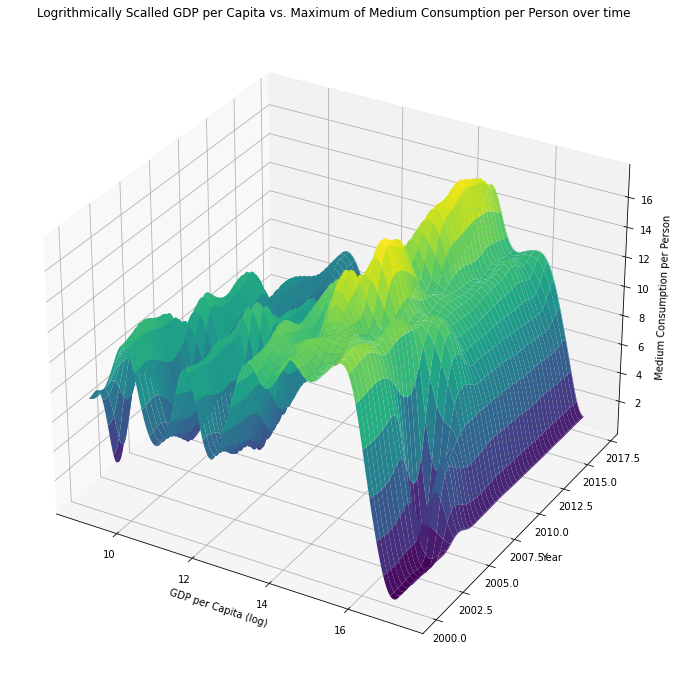

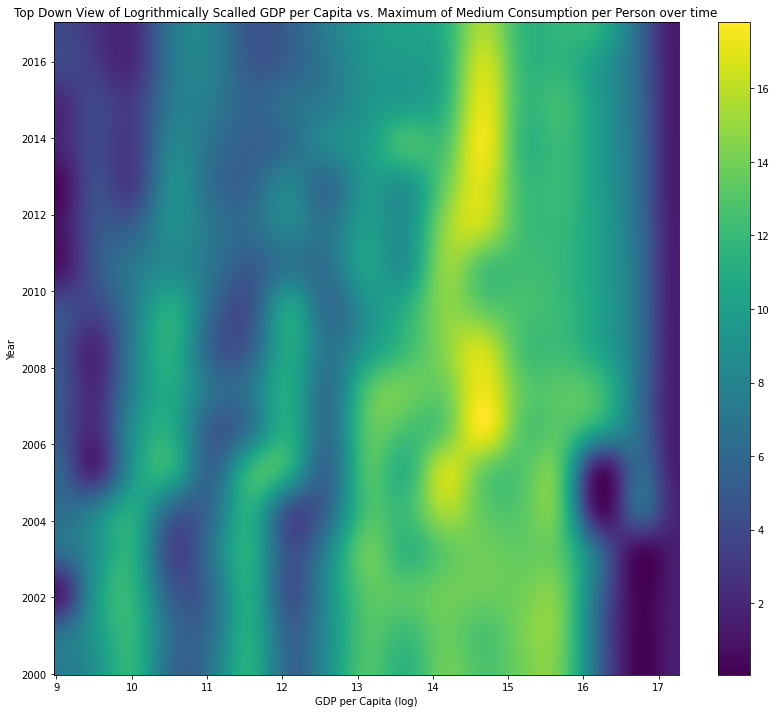

In [92]:
## maximum datapoints mapping log2(gdp_pc_2011) and average abv to total alcohol consumption, 2d interpolation and gauss blur smoothing
fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')
ax.set_xlabel('GDP per Capita (log)')
ax.set_ylabel('Year')
ax.set_zlabel('Medium Consumption per Person');
ax.title.set_text("Logrithmically Scalled GDP per Capita vs. Maximum of Medium Consumption per Person over time")
x_test , y_test, z_max = make_surf_plot_points(all_pts, 16, 25, lambda x,y : np.max([x,y]), sigma=5, add_y_bound=(0,1), blur_iter = 1, adj_blur = False, smooth_kind=2)

ax.plot_surface(x_test, y_test, z_max, cmap='viridis')
plt.show()

# Top down of the graph
fig = plt.figure(figsize=(14,12))
ax = plt.axes()
ax.set_xlabel('GDP per Capita (log)')
ax.set_ylabel('Year')
ax.title.set_text("Top Down View of Logrithmically Scalled GDP per Capita vs. Maximum of Medium Consumption per Person over time")

c = ax.pcolormesh(x_test, y_test, z_max, cmap='viridis', vmin=np.min(z_max), vmax=np.max(z_max))

fig.colorbar(c, ax=ax)
plt.show()

By making the average of data points, we can see the trend in alcohol consumption clearer than the maximum alcohol consumption.

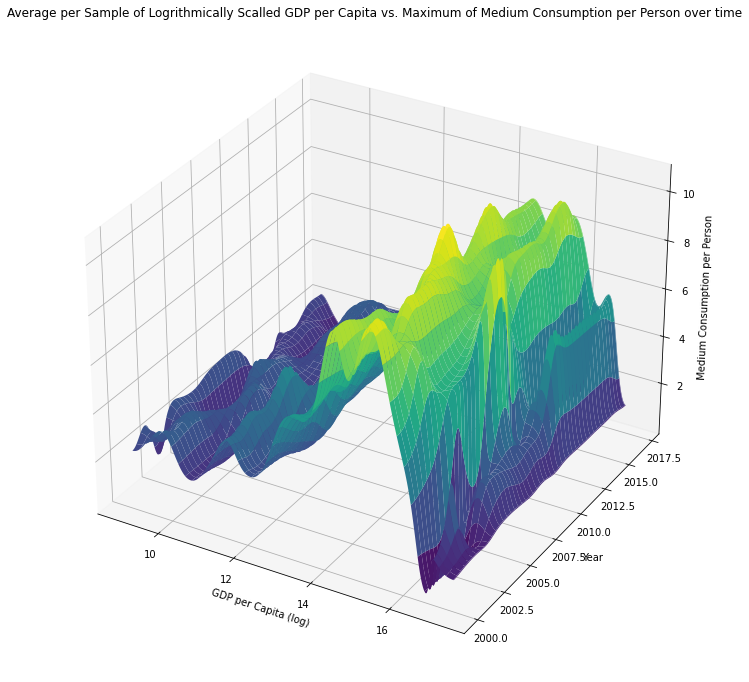

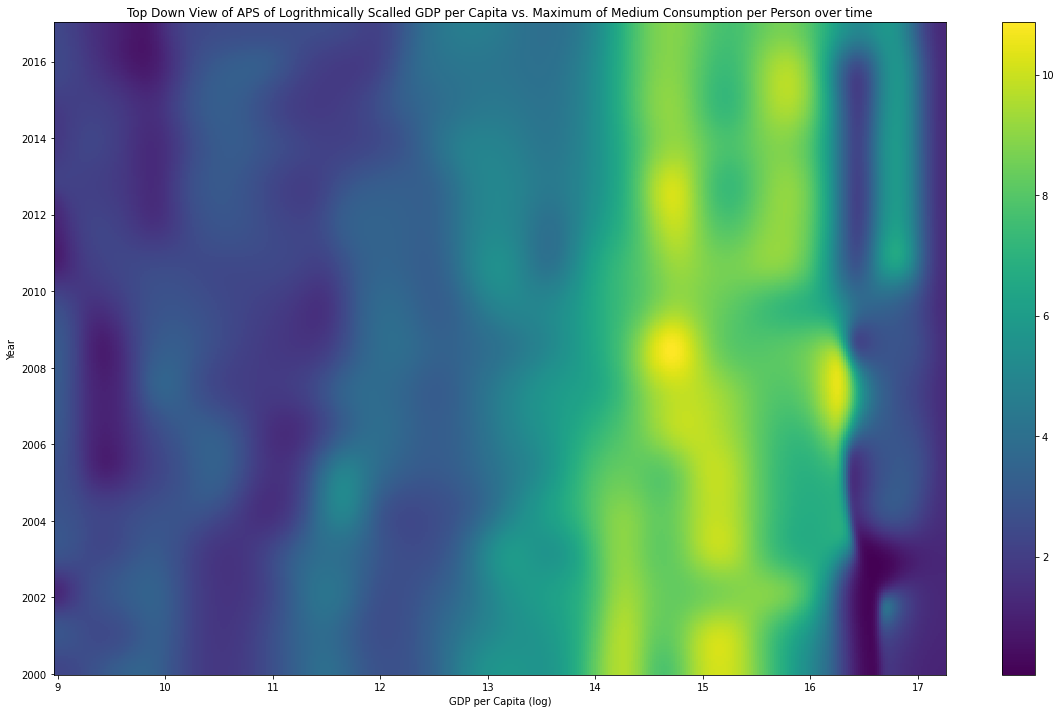

In [93]:
## avg of datapoints mapping log2(gdp_pc_2011) and average abv over time, 2d interpolation and gauss blur smoothing
fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')

ax.set_xlabel('GDP per Capita (log)')
ax.set_ylabel('Year')
ax.set_zlabel('Medium Consumption per Person');
ax.title.set_text("Average per Sample of Logrithmically Scalled GDP per Capita vs. Maximum of Medium Consumption per Person over time")

x_test , y_test, z_tot = make_surf_plot_points(all_pts, 16, 25, lambda x,y : y + 1, sigma=5, add_y_bound=(0,1), blur_iter = 1, adj_blur = False, smooth_kind=2)
x_test , y_test, z_test = make_surf_plot_points(all_pts, 16, 25, lambda x,y : x+y, sigma=5, add_y_bound=(0,1), blur_iter = 1, adj_blur = False, smooth_kind=2)
z_test = z_test / z_tot
ax.plot_surface(x_test, y_test, z_test, cmap='viridis')
plt.show()

## top down view of graph
fig = plt.figure(figsize=(20,12))
ax = plt.axes()
ax.set_xlabel('GDP per Capita (log)')
ax.set_ylabel('Year')
ax.title.set_text("Top Down View of APS of Logrithmically Scalled GDP per Capita vs. Maximum of Medium Consumption per Person over time")
c = ax.pcolormesh(x_test, y_test, z_test, cmap='viridis', vmin=np.min(z_test), vmax=np.max(z_test))

fig.colorbar(c, ax=ax)
plt.show()

The top-down representation of this data does a much better job of displaying the correlation. The green represents the highest alcohol consumption while the blue is the lower alcohol consumption. There is a very high concentration of alcohol consumption from the GDP per capita 14 to 16. This indicates a correlation between GDP per capita and alcohol consumption more so than alcohol consumption over time. 

<center>
    <h3>Hypothesis testing</h3>
</center>



Before we can analyze the relation between GDP and alcohol consumption, we must first take care of the remaining missing values. To do so we use a K-nearest neighbor approach.

In [94]:
# this dataframe will contain all missing values
filled_df = new_comb_df[['code','year','gdp_pc_2011_mb','population','wine_mi','beer_mi','spirits_mi','other_mi']]
filled_df = filled_df.replace(-1,np.nan)
filled_df

consumption_imputer = filled_df

# when working with a knn model we can't process string data, so we change coutry codes to numeric values
le = preprocessing.LabelEncoder()
le.fit(consumption_imputer['code'])
consumption_imputer['code'] = le.transform(consumption_imputer['code'])
consumption_imputer

# in order to allow distance functions to work for k nearest neighbors, we change all values to be normalized between 0 and 1
scaler = preprocessing.MinMaxScaler()
consumption_imputer = pd.DataFrame(scaler.fit_transform(consumption_imputer), columns=consumption_imputer.columns)

consumption_imputer_na = consumption_imputer
consumption_imputer = filled_df.dropna()
consumption_imputer

,code,year,gdp_pc_2011_mb,population,wine_mi,beer_mi,spirits_mi,other_mi
5,0,2005.0,1187.0,26335000,0.0008,0.009,0.006,0.00
6,0,2006.0,1257.0,27154000,0.0080,0.011,0.007,0.00
7,0,2007.0,1447.0,27387000,0.0090,0.007,0.002,0.00
8,0,2008.0,1464.0,27706000,0.0009,0.009,0.018,0.00
9,0,2009.0,1669.0,28484000,0.0000,0.010,0.000,0.00
...,...,...,...,...,...,...,...,...
2817,166,2012.0,1623.0,12620000,0.0500,2.070,0.470,1.34
2818,166,2013.0,1801.0,13183000,0.0500,2.120,0.470,1.47
2819,166,2014.0,1797.0,13772000,0.0600,2.230,0.360,1.57
2820,166,2015.0,1759.0,14230000,0.0600,1.930,0.360,1.49


In [95]:
fields_to_fill = ['wine_mi','beer_mi','spirits_mi','other_mi']

X = consumption_imputer[consumption_imputer[fields_to_fill[0]] >= 0][['year','gdp_pc_2011_mb','population']]
Y = consumption_imputer[consumption_imputer[fields_to_fill[0]] >= 0][fields_to_fill[0]]

x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.7)

Text(0.5, 1.0, 'detecting ideal k')

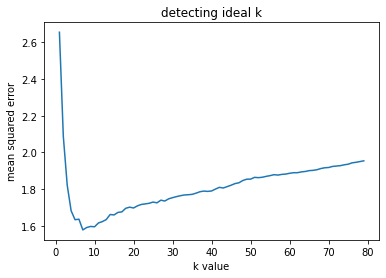

In [96]:
fig, ax = plt.subplots()
num_k = np.arange(1,80,1)
accuracy = {} #records the accuracy of each neighbor setting

for neighbors in num_k:
  knn = KNeighborsRegressor(n_neighbors=neighbors)
  model = knn.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  mse = mean_squared_error(y_test,y_pred)
  accuracy[neighbors] = mse


plotable_x = np.fromiter(accuracy.keys(), dtype=float)
plotable_y = np.fromiter(accuracy.values(), dtype=float)
ax.plot(plotable_x,plotable_y)
ax.set_xlabel('k value')
ax.set_ylabel('mean squared error')
ax.set_title('detecting ideal k')

In [97]:
consumption_imputer_na = filled_df.fillna(-1)

def fillField(field):

  X = consumption_imputer[consumption_imputer[field] >= 0][['year','gdp_pc_2011_mb','population']]
  Y = consumption_imputer[consumption_imputer[field] >= 0][field]
  x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.7)

  ideal_k = min(accuracy, key=accuracy.get) # this k value produced the least amount of error so we will use it!
  knn = KNeighborsRegressor(n_neighbors=ideal_k)
  model = knn.fit(x_train, y_train) # we now have the actual interpolation model that we wish to use

  

  cond = (consumption_imputer_na[field] == -1)
  x_operate = consumption_imputer_na[cond][['year','gdp_pc_2011_mb','population']]
  x_operate
  mystery_vals = model.predict(x_operate)

  index_map = []
  j = 0
  for i, x in x_operate.iterrows():
    index_map.append(i)
    j = j + 1

  consumption_imputer_na.iloc[index_map, consumption_imputer_na.columns.get_loc(field)] = mystery_vals
  consumption_imputer_na.iloc[index_map]

# runs through all different fields
consumption_imputer_na['total_consumption'] = 0
for field in fields_to_fill:
  fillField(field)
  consumption_imputer_na['total_consumption'] = consumption_imputer_na['total_consumption'] + consumption_imputer_na[field]


consumption_imputer_na['code'] = le.inverse_transform(consumption_imputer_na['code'])
data_analysis = consumption_imputer_na
data_analysis

,code,year,gdp_pc_2011_mb,population,wine_mi,beer_mi,spirits_mi,other_mi,total_consumption
0,AFG,2000.0,735.000000,22461000,1.092857,1.299286,2.193571,0.502857,5.088571
1,AFG,2001.0,692.000000,22507000,1.082857,1.395000,1.585000,0.502857,4.565714
2,AFG,2002.0,1088.000000,23600000,0.597714,2.012857,1.467143,0.232000,4.309714
3,AFG,2003.0,1112.000000,25005000,0.059257,1.052429,1.237286,0.122043,2.471014
4,AFG,2004.0,1107.000000,25698000,0.069571,1.387571,0.988429,1.686086,4.131657
...,...,...,...,...,...,...,...,...,...
2834,WORLD,2012.0,13815.576851,6992922992,0.150000,1.555714,3.640000,0.000071,5.345786
2835,WORLD,2013.0,14030.044051,7072213016,0.150000,1.555714,3.640000,0.000071,5.345786
2836,WORLD,2014.0,14261.271531,7152269064,0.150000,1.555714,3.640000,0.000071,5.345786
2837,WORLD,2015.0,14493.906019,7231374064,0.150000,1.555714,3.640000,0.000071,5.345786


With our imputed alcohol consumption metrics, we can begin to search for potential correlations.

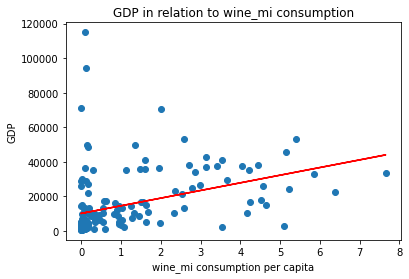

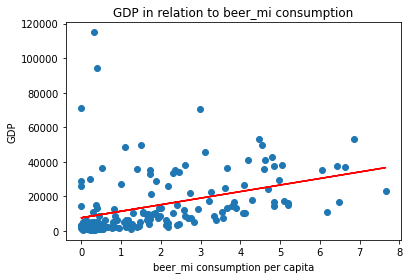

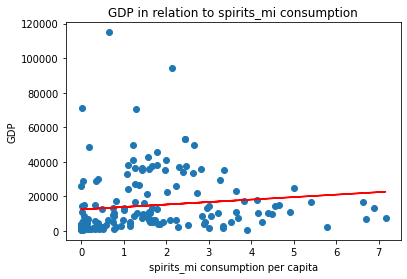

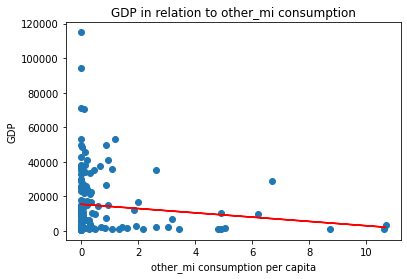

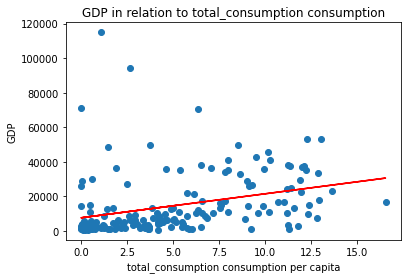

In [98]:
fields = ['wine_mi','beer_mi','spirits_mi','other_mi','total_consumption']

cond = (data_analysis['year'] == 2005)
yearFocus = data_analysis.loc[cond,:]

figures = []
for field in fields:
    fig, ax = plt.subplots()
    figures.append((fig,ax))

for i, field in enumerate(fields):
    m, b = np.polyfit(yearFocus[field],yearFocus['gdp_pc_2011_mb'],1)
    figures[i][1].plot(yearFocus[field],m*yearFocus[field]+b,color='red')
    figures[i][1].scatter(yearFocus[field],yearFocus['gdp_pc_2011_mb'])
    figures[i][1].set_xlabel(f'{field} consumption per capita')
    figures[i][1].set_ylabel("GDP")
    figures[i][1].set_title(f"GDP in relation to {field} consumption")

Before any analysis is performed, it is of utmost importance to note that the presence of a linear interpretation of the relationship does not imply that the data is linear, rather we can use it to decide whether it is possibly linear in the first place. From a blanket look, we see an interesting trend in the data.

While for all but the other categories, the data follows a positive correlation, the highest GDP points seem to have a high error rate when compared to the regression line. This pushes us to analyze the relationship for certain GDP sub-sections.

In [99]:
mean_gdp = data_analysis['gdp_pc_2011_mb'].mean()
std_gdp = data_analysis['gdp_pc_2011_mb'].std()

print(f"The mean of the gdp is {mean_gdp} and the std is {std_gdp}")

The mean of the gdp is 15715.212842491961 and the std is 18142.444024374647


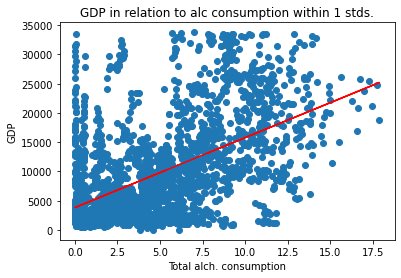

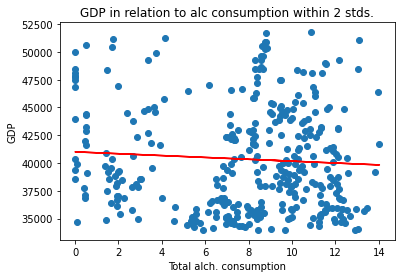

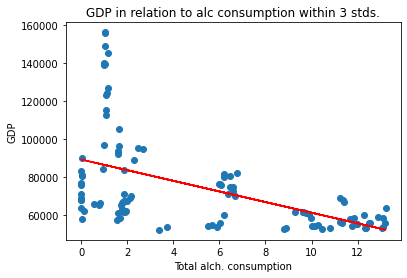

In [100]:
figures = []
for i in range(1,4):
    fig, ax = plt.subplots()
    figures.append((fig,ax))

    gdp = data_analysis['gdp_pc_2011_mb']

    upper_max = mean_gdp + (std_gdp*i)
    lower_max = mean_gdp + (std_gdp*(i-1))
    lower_min = mean_gdp - (std_gdp*i)
    upper_min = mean_gdp - (std_gdp*(i-1))

    if i != 3:
        payFocus1 = data_analysis[(data_analysis['gdp_pc_2011_mb'] >= lower_max) & (data_analysis['gdp_pc_2011_mb'] <= upper_max)]
        payFocus2 = data_analysis[(data_analysis['gdp_pc_2011_mb'] >= lower_min) & (data_analysis['gdp_pc_2011_mb'] <= upper_min)]
    else:
        payFocus1 = data_analysis[(data_analysis['gdp_pc_2011_mb'] >= lower_max)]
        payFocus2 = data_analysis[(data_analysis['gdp_pc_2011_mb'] <= upper_min)]

    payFocus = pd.concat([payFocus1,payFocus2])
    m, b = np.polyfit(payFocus['total_consumption'],payFocus['gdp_pc_2011_mb'],1)
    figures[i-1][1].plot(payFocus['total_consumption'],m*payFocus['total_consumption']+b,color='red')
    figures[i-1][1].scatter(payFocus['total_consumption'],payFocus['gdp_pc_2011_mb'])
    figures[i-1][1].set_xlabel(f'Total alch. consumption')
    figures[i-1][1].set_ylabel("GDP")
    figures[i-1][1].set_title(f"GDP in relation to alc consumption within {i} stds.")

It would appear that our intuition may be right.  For average GDP it would appear that alcohol consumption has a positive correlation, but for wealthy and poor zones, the less alcohol, the higher the GDP. What this appears to tell us is that at the extremes of both poverty and wealth, the relationship between GDP and alcohol consumption becomes stronger.

<center>
    <h3>Conclusion</h3>
</center>

Based on our evaluation and analysis, average GDP and alcohol consumption has a positive correlation. This indicates that for the majority of countries, the alcohol consumption of their citizens does not impede their productivity and is beneficial to a country. We also found that there is a positive correlation between beer, wine, and spirit consumption and GDP while there is a negative correlation between other alcoholic drink consumption and GDP. 

Another interesting observation that we found was the GDP vs alcohol consumption in standard deviations. What we found was that countries with GDP in one standard deviation had a positive correlation with alcohol consumption. However, countries with GDP of two and three standard deviations had a negative correlation with alcohol consumption. This means that countries that are either very wealthy or very poor may drink less alcohol on average. For poor countries, it makes sense as their citizens may not have the finances to buy alcohol but for wealthy countries this is surprising. This could indicate that wealthy countries don't drink as much alcohol thus making their citizens more productive.

If anything this tutorial should show you that alcohol consumption in a country is not immediately a bad thing.

The CSV and DTA files that are used in this tutorial are available on <a href = "https://github.com/evanamay/CMSC320-Final-Project">GitHub</a>

<hr>